In [1]:
CONFIG_PATH = "configs/small_sample_sub_minority.yml"
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
config = get_config(CONFIG_PATH, "_curation", print_config = False)
active_user_votes_thres = config["active_user_votes_thres"]
batch_size = config["batch_size"]

为了使用邮件提醒功能，请设置环境变量MY_QQ_EMAIL（QQ邮箱地址）与MY_QQ_EMAIL_PWD（QQ邮箱授权码）
------------------ 2022-08-09 20:50:01 ------------------
GPU ready...
Smart using cuda:3


In [2]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from process_data import get_model_input
from model import get_best_model
from matplotlib import pyplot as plt
from venn import venn, pseudovenn
import time
import re
submission_sentiment_map = {}
submission_class_map = {}

Version 7.5.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.


##### Preprocess

Load model and data

In [3]:
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)
model, token_embedding = get_best_model(config, categorical_features, string_features, original_feature_map)
model.eval()
all_users = list(range(num_all_users + 1))

------------------ 2022-08-09 20:50:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:349 get_model_input
Loading prepared data...
------------------ 2022-08-09 20:50:03 ------------------
------------------ 2022-08-09 20:50:06 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:248 get_tokenizer
0 / 1.  original_token_num num val: 30522
------------------ 2022-08-09 20:50:06 ------------------
------------------ 2022-08-09 20:50:07 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:260 get_tokenizer
0 / 2.  latest_token_num num val: 153833
------------------ 2022-08-09 20:50:07 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------ 2022-08-09 20:50:08 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:110 load_model
Loading best model...
------------------ 2022-08-09 20:50:08 ------------------


Collect submissions and active users in different subreddits

In [4]:
def get_subreddits_submissions(train_data:pd.DataFrame, test_data:pd.DataFrame, user_votes_thres = 0):
    subreddit_votes_counter = Counter()
    subreddit_active_users = defaultdict(Counter)
    subreddit_train_submissions = defaultdict(dict)
    subreddit_test_submissions = defaultdict(dict)
    all_submissions = dict()
    for i, row in train_data.iterrows():
        subreddit_votes_counter[row["SUBREDDIT"]] += 1
        subreddit_active_users[row["SUBREDDIT"]][row["USERNAME"]] += 1
        if row["SUBMISSION_ID"] not in subreddit_train_submissions[row["SUBREDDIT"]]:
            subreddit_train_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    for subreddit in subreddit_active_users:
        users_vote_count = subreddit_active_users[subreddit]
        subreddit_active_users[subreddit] = {user for user in users_vote_count if users_vote_count[user] >= user_votes_thres}
    for i, row in test_data.iterrows():
        if row["SUBMISSION_ID"] not in subreddit_test_submissions[row["SUBREDDIT"]]:
            subreddit_test_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    return subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions

subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions = get_subreddits_submissions(train_data, test_data, user_votes_thres = active_user_votes_thres) # subreddit_votes_counter, subreddit_users, subreddit_train_submissions are based on train_data, subreddit_test_submissions are based on test_data

Record down existing votes

So that we can use them to substitute the predicted votes

In [5]:
def record_existing_votes(train_data:pd.DataFrame):
    # collect existing votes
    existing_votes = {}
    existing_user_updown_votes = defaultdict(Counter)
    existing_user_votes = Counter()
    existing_submission_votes = defaultdict(Counter)
    usernames = train_data["USERNAME"].to_list()
    sub_ids = train_data["SUBMISSION_ID"].to_list()
    votes = train_data["VOTE"].to_list()
    for row_i in range(len(train_data)):
        existing_votes[f'{usernames[row_i]}-{sub_ids[row_i]}'] = votes[row_i]
        existing_user_updown_votes[usernames[row_i]][votes[row_i]] += 1
        existing_user_votes[usernames[row_i]] += 1
        existing_submission_votes[sub_ids[row_i]][votes[row_i]] += 1
    return existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes
existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes = record_existing_votes(train_data)


#### Predict votes for all the users on all submissions

Define required functions

In [6]:
from typing import Union
# from tqdm import tqdm
from tqdm.notebook import tqdm
from train import evaluate_model
from model import get_tokenizer

def convert_group_users_subreddit_submissions_data(group_users:Union[set,list], unique_submissions:dict):
    group_users_submissions_data = []
    if type(unique_submissions) == dict:
        unique_submissions = pd.DataFrame(list(unique_submissions.values()))

    for user in tqdm(group_users):
        # for submission_id in unique_submissions:
        #     submission:pd.DataFrame = unique_submissions[submission_id].copy(deep=True)
        #     submission["USERNAME"] = user
        #     group_users_submissions_data.append(submission)
        submissions = unique_submissions.copy(deep=True)
        submissions["USERNAME"] = [user] * len(submissions) # it doesn't matter whether the user itself is in UPVOTED_USERS / DOWNVOTED_USERS: we will substitute it with real votes
        group_users_submissions_data.append(submissions)

    group_users_submissions_data = pd.concat(group_users_submissions_data,axis=0)
    return group_users_submissions_data
def predict_group_users_submissions_votes(model, group_users_submissions_data, batch_size):
    # predict unseen votes
    return evaluate_model(config, model, data=group_users_submissions_data, weights = None, batch_size=config["batch_size"], sample_voted_users=False, extra_input = extra_input, ret = "prediction") # ndarray size: (3423664, 1)
pred_all_user_submission_vote_score_matrix = None

# model.device = "cuda:0"
def get_group_user_submission_vote_score_matrix(predicted_group_users_submissions_votes:np.ndarray, group_users, group_users_submissions_data:pd.DataFrame, existing_votes, existing_pred_user_submission_vote_score_matrix = None, upvote_confidence_thres = 0):
    if existing_pred_user_submission_vote_score_matrix is not None:
        pred_user_submission_vote_score_matrix = existing_pred_user_submission_vote_score_matrix
    else:
        all_sub_ids = group_users_submissions_data["SUBMISSION_ID"].unique()
        pred_user_submission_vote_score_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = float), columns=all_sub_ids)
    pred_user_submission_vote_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = int), columns=all_sub_ids) # use ground truth vote if available, -1 for not in data
    each_submission_votes = {}
    each_user_confidence = defaultdict(list)
    submission_ids = group_users_submissions_data["SUBMISSION_ID"].to_numpy()
    usernames = group_users_submissions_data["USERNAME"].to_numpy()
    for row_i in tqdm(range(len(group_users_submissions_data))):
        submission_id = submission_ids[row_i]
        username = usernames[row_i]
        if existing_pred_user_submission_vote_score_matrix is not None:
            vote_score = existing_pred_user_submission_vote_score_matrix[username, submission_id]
        else:
            vote_score = predicted_group_users_submissions_votes[row_i, 0]
            pred_user_submission_vote_score_matrix[username, submission_id] = vote_score
        if f'{username}-{submission_id}' not in existing_votes:
            vote = int(vote_score >= 0.5 + upvote_confidence_thres)
        else: # use existing votes if available
            vote = int(existing_votes[f'{username}-{submission_id}'] >= 0.5)
            
        if submission_id not in each_submission_votes:
            each_submission_votes[submission_id] = [0, 0]
        each_user_confidence[username].append(abs(vote_score - 0.5))
        pred_user_submission_vote_matrix.at[username, submission_id] = vote
        each_submission_votes[submission_id][vote] += 1
    assert (pred_user_submission_vote_matrix.to_numpy() != -1).sum() > 0
    
    # analyze user confidence
    for username in each_user_confidence:
        each_user_confidence[username] = float(np.mean(each_user_confidence[username]))
        
    # calculate %upvotes for each submission
    for submission_id in each_submission_votes:
        each_submission_votes[submission_id].append(each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])) # %upvotes
    return each_submission_votes, each_user_confidence, pred_user_submission_vote_score_matrix, pred_user_submission_vote_matrix
def get_group_users_preferred_submissions(each_submission_votes:dict, upvote_ratio_thres = 0.5):
    # sort submissions using %upvotes
    group_submissions_ranking = list(each_submission_votes.keys())
    group_submissions_ranking.sort(reverse=True, key=lambda id: each_submission_votes[id][-1])
    
    # include submissions to preferred_submissions where %upvotes is higher than threshold
    group_preferred_submissions = set()
    for submission_id in group_submissions_ranking:
        if each_submission_votes[submission_id][-1] >= upvote_ratio_thres:
            group_preferred_submissions.add(submission_id)
    
    return group_preferred_submissions, group_submissions_ranking

def get_group_users_real_vote(group_users:Union[set,list], unique_submissions:dict, existing_votes, metric = "upvote_rate"):
    all_sub_ids = list(unique_submissions.keys())
    pred_user_submission_vote_score_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = float), columns=all_sub_ids)
    pred_user_submission_vote_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = int), columns=all_sub_ids)
    each_submission_votes = {}
    for submission_id in unique_submissions:
        each_submission_votes[submission_id] = [0, 0]
    for username in group_users:
        for submission_id in unique_submissions:
            if f'{username}-{submission_id}' in existing_votes:
                vote = int(existing_votes[f'{username}-{submission_id}'] >= 0.5)
                pred_user_submission_vote_matrix.at[username, submission_id] = vote
                pred_user_submission_vote_score_matrix[username, submission_id] = vote
                each_submission_votes[submission_id][vote] += 1
                
    each_user_confidence = {user: [0.5] for user in group_users}
    
    # calculate %upvotes for each submission
    for submission_id in each_submission_votes:
        if metric == "upvote_rate":
            if each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1] == 0:
                metric_res = -1
            else:
                metric_res = each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])
        elif metric == "#upvote-#downvote":
            metric_res = each_submission_votes[submission_id][1] - each_submission_votes[submission_id][0]
        each_submission_votes[submission_id].append(metric_res)
        
    
    return each_submission_votes, each_user_confidence, pred_user_submission_vote_score_matrix, pred_user_submission_vote_matrix

Convert data to model input, then run model to make predictions, and obtain prediction score matrix and vote matrix. Note that we use actual votes to replace predicted votes when available.

_!!! This process can be time consuming & need more than 200G memory for medium sized dataset, and is not necessary if we use user_embedding to cluster active users_

In [7]:
if config["user_grouping_method"] == "predict_all_submissions":
    # Convert data to model input
    # TODO: not all users
    all_users_submissions_data = convert_group_users_subreddit_submissions_data(all_users, all_submissions)

    # run model to make predictions
    model.to(model.device)
    predicted_all_users_submissions_votes = predict_group_users_submissions_votes(model, all_users_submissions_data, batch_size)
    debug(predicted_all_users_submissions_votes=predicted_all_users_submissions_votes)

    import pickle
    pickle.dump(predicted_all_users_submissions_votes, open("output/predicted_all_users_submissions_votes.pt", "wb"))
    # predicted_all_users_submissions_votes = pickle.load(open("output/predicted_all_users_submissions_votes.pt", "rb"))

    # Obtain prediction score matrix and vote matrix. We use actual votes to replace predicted votes when available
    all_submission_votes, all_users_confidence, pred_all_user_submission_vote_score_matrix, pred_all_user_submission_vote_matrix = get_group_user_submission_vote_score_matrix(predicted_all_users_submissions_votes, all_users, all_users_submissions_data, existing_votes)
    
    # all_users_preferred_submissions, all_preferred_submissions_ranking = get_group_users_preferred_submissions(all_submission_votes, upvote_ratio_thres = config["upvote_ratio_thres"])

Calculate Pearson correlation between users

In [8]:
if config["user_grouping_method"] == "predict_all_submissions":
    debug((pred_all_user_submission_vote_matrix==-1).any())
    debug(pred_all_user_submission_vote_score_matrix=pred_all_user_submission_vote_score_matrix, pred_all_user_submission_vote_matrix=pred_all_user_submission_vote_matrix)
    vote_score_pearson_corr = np.corrcoef(pred_all_user_submission_vote_score_matrix) # (697, 697)
    debug(vote_score_pearson_corr=vote_score_pearson_corr)

#### Perform curation on a subreddit

Select a subreddit from the most popular subreddits

In [9]:
common_subreddits_counts = subreddit_votes_counter.most_common(20)
prompt = []
for subreddit_id, vote_counts in common_subreddits_counts:
    subreddit_name_str = (original_feature_map['SUBREDDIT'][subreddit_id] + ', ') if 'SUBREDDIT' in original_feature_map else ''
    prompt.append(f"Subreddit {subreddit_id}: {subreddit_name_str}{vote_counts} votes")
prompt = "\n".join(prompt)
a_subreddit = input(f"{prompt}\nSelect a subreddit: ")
if 'SUBREDDIT' in original_feature_map:
    a_subreddit = int(a_subreddit)
    subreddit_name_str = (f" ({original_feature_map['SUBREDDIT'][a_subreddit]})")
else:
    subreddit_name_str =  ''
print_log(config["log_path"], f"Selected subreddit: {a_subreddit}{subreddit_name_str}")
a_subreddit_active_users:set = subreddit_active_users[a_subreddit]
print_log(config["log_path"], f"In train data, subreddit {a_subreddit} have {len(a_subreddit_active_users)} active users (who votes >= {active_user_votes_thres} times), {subreddit_votes_counter[a_subreddit]} votes and {len(subreddit_train_submissions[a_subreddit])} unique submissions. In test data, subreddit {a_subreddit} have {len(subreddit_test_submissions[a_subreddit])} unique submissions.") 

------------------ 2022-08-09 20:51:10 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Selected subreddit: r/politics
------------------ 2022-08-09 20:51:10 ------------------
------------------ 2022-08-09 20:51:10 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
In train data, subreddit r/politics have 131 active users (who votes >= 5 times), 3676 votes and 965 unique submissions. In test data, subreddit r/politics have 409 unique submissions.
------------------ 2022-08-09 20:51:10 ------------------


In [28]:
user_grouping_method = config["user_grouping_method"]
user_grouping_method =  "manual" # "manual" #TODO: change this
manual_user_groups = config["manual_user_groups"]
# manual_user_groups = {"Conservative": {66, 39, 10, 44, 16, 60}, "Democratic":{0, 65, 64, 37, 49, 52, 20, 22, 23, 26, 29}}
debug(user_grouping_method=user_grouping_method)


------------------ 2022-08-09 21:53:51 ------------------
DEBUG: 1 vars: ['user_grouping_method'], at <ipython-input-28-e0766744eb0c>:5 <module>
0 / 12.  user_grouping_method str len 6: manual
------------------ 2022-08-09 21:53:51 ------------------


In [29]:
import sklearn.decomposition

def get_bool_vec(selected_ids, vec_size):
    bool_vec = torch.zeros([vec_size], dtype = bool)
    for user in selected_ids:
        bool_vec[user] = True
    return bool_vec

def get_user_reps(selected_users, all_user_embedding, train_data:pd.DataFrame = None, selected_submissions = None, user_grouping_method = "neural"):
    assert all_user_embedding is not None
    selected_users_bool_vec = get_bool_vec(selected_users, all_user_embedding.shape[0])
    # user_user_i_map = {}
    selected_user_i_user_map = {}
    user_i = 0
    for user, in_subreddit in enumerate(selected_users_bool_vec):
        if in_subreddit:
            # user_user_i_map[user] = user_i
            selected_user_i_user_map[user_i] = user
            user_i += 1
    # assert len(user_user_i_map) == len(user_i_user_map)
    selected_users_reps = None
    if "neural" in user_grouping_method:
        selected_users_reps = all_user_embedding[selected_users_bool_vec, :]
    elif "votes" in user_grouping_method:
        assert train_data is not None and selected_submissions is not None
        sub_sub_i_map = {sub: sub_i for sub_i, sub in enumerate(list(selected_submissions.keys()))}
        users_reps = torch.zeros([all_user_embedding.shape[0], len(selected_submissions)])
        for row_i, row in train_data.iterrows():
            if row["USERNAME"] in selected_users and row["SUBMISSION_ID"] in selected_submissions:
                vote = 1 if row["VOTE"] == 1 else -1
                users_reps[row["USERNAME"], sub_sub_i_map[row["SUBMISSION_ID"]]] = vote
        selected_users_reps = users_reps[selected_users_bool_vec, :]
        users_vote_sum = (selected_users_reps * selected_users_reps).sum(axis = -1, keepdim= True)
        assert (users_vote_sum != 0).all()
        # selected_users_reps = selected_users_reps / users_vote_sum # average votes on each submission
        debug(selected_users_reps_before_PCA=selected_users_reps.shape)
        pca_solver = sklearn.decomposition.PCA(n_components=0.95)
        selected_users_reps = pca_solver.fit_transform(selected_users_reps)
        debug(selected_users_reps_after_PCA = selected_users_reps.shape)

    return selected_users_reps, selected_user_i_user_map


##### Obtain representations for active users

User representation will be used to cluster users into groups if `user_grouping_method` is "`neural`" or "`vote`"

Either use this one... (clustering using vote prediction score on submissions in this subreddit, make sure `pred_all_user_submission_vote_score_matrix` is available)

In [12]:
if pred_all_user_submission_vote_score_matrix is not None:
    debug(pred_all_user_submission_vote_score_matrix=pred_all_user_submission_vote_score_matrix)
    subreddit_submissions_bool_vec = get_bool_vec(subreddit_test_submissions[a_subreddit].keys(), pred_all_user_submission_vote_score_matrix.shape[1])
    a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=pred_all_user_submission_vote_score_matrix[:, subreddit_submissions_bool_vec], train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)

Or this one... (cluster using user_embedding or sparse actual votes)

In [30]:
if pred_all_user_submission_vote_score_matrix is None:
    all_username_tokens = [f"USERNAME_{user_i}" for user_i in all_users]
    all_username_token_ids = torch.tensor(model.tokenizer.convert_tokens_to_ids(all_username_tokens))
    all_username_token_ids = all_username_token_ids.to(model.device); model = model.to(model.device)
    with torch.no_grad():
        user_embedding = model.lm_encoder.embeddings.word_embeddings(all_username_token_ids)
    # debug(all_username_tokens=all_username_tokens, all_username_token_ids=all_username_token_ids, user_embedding=user_embedding)
    a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], user_grouping_method = user_grouping_method)
    debug(a_subreddit_active_users_reps=a_subreddit_active_users_reps)

------------------ 2022-08-09 21:54:00 ------------------
DEBUG: 1 vars: ['a_subreddit_active_users_reps'], at <ipython-input-30-6d87cb7ec640>:9 <module>
0 / 13.  a_subreddit_active_users_reps None
------------------ 2022-08-09 21:54:00 ------------------


##### Cluster active users into multiple groups

In [31]:
from reddit import get_user_info

def get_user_groups(selected_users_reps, selected_user_i_user_map:dict, user_grouping_method = "neural", existing_user_votes=None, manual_user_groups=None, train_data=None):
    group_centers = None
    users_in_groups = defaultdict(set)
    
    if "manual" in user_grouping_method:
        if manual_user_groups is not None:
            users_in_groups.update(manual_user_groups)
        else:
            user_preferences = defaultdict(dict)
            usernames = train_data["USERNAME"].to_list()
            votes = train_data["VOTE"].to_list()
            submissions_text = train_data["SUBMISSION_TEXT"].to_list()
            for row_i, username in enumerate(usernames):
                vote = votes[row_i]
                submission_text = submissions_text[row_i]
                if vote not in user_preferences[username]:
                    user_preferences[username][vote] = []
                user_preferences[username][vote].append(submission_text)
            all_users = list(user_preferences.keys())
            group_x = len(users_in_groups)
            for _ in range(20):
                possible_user = random.choice(all_users)
                user_info, user_info_str = get_user_info(possible_user)
                if len(input(f"Include user {possible_user}? \n{user_info_str} \n{user_preferences[possible_user]}")) > 0:
                    users_in_groups[group_x].add(possible_user)
            
    if "neural" in user_grouping_method or "votes" in user_grouping_method:
        n_groups = int(len(selected_user_i_user_map) / 5) # TODO: change how many users in a group
        debug(num_selected_users = len(selected_user_i_user_map), n_groups=n_groups) # n_groups: 118
        debug("Begin grouping...")
        from sklearn.cluster import KMeans
        grouping = KMeans(n_clusters = n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        group_centers = grouping.cluster_centers_
        """
        from sklearn.cluster import AgglomerativeClustering
        grouping = AgglomerativeClustering(linkage = "complete").fit(selected_users_reps)
        """
        """
        from sklearn.cluster import SpectralClustering
        grouping = SpectralClustering(n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        """
        labels = grouping.labels_ # grouping.labels_: [584 350 948 ... 813 938 152]
        """
        from sklearn.mixture import GaussianMixture
        labels = GaussianMixture(n_groups, random_state = 42, verbose = 0).fit_predict(selected_users_reps)
        """
        usernames_in_groups = defaultdict(set)
        for user_i, group_x in enumerate(labels): 
            users_in_groups[group_x].add(selected_user_i_user_map[user_i])
            usernames_in_groups[group_x].add(original_feature_map["USERNAME"][selected_user_i_user_map[user_i]])
        debug(group_user_num=str({group_x: len(users_in_groups[group_x]) for group_x in users_in_groups}))
        debug(usernames_in_groups=str(usernames_in_groups))
        
    if  "single_user_as_group" in user_grouping_method or  "all_user_as_group" in user_grouping_method:
        assert existing_user_votes is not None
        all_users = list(selected_user_i_user_map.values())
        all_users.sort(key=lambda x:existing_user_votes[x])
        if  "single_user_as_group" in user_grouping_method:
            all_users = all_users[:10] + all_users[-10:]
            for i, user in enumerate(all_users):
                users_in_groups[i] = {user}
            # users_in_groups = {i: {user} for i,user in selected_user_i_user_map.items()}
        if  "all_user_as_group" in user_grouping_method:
            users_in_groups[len(users_in_groups)] = all_users
    
    if "none" in user_grouping_method:
        users_in_groups[len(users_in_groups)] = []
            
    return users_in_groups, group_centers

if type(a_subreddit_active_users_reps) == torch.tensor: a_subreddit_active_users_reps = a_subreddit_active_users_reps.cpu()
users_in_groups, group_centers = get_user_groups(a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map, user_grouping_method=user_grouping_method, existing_user_votes=existing_user_votes, manual_user_groups=manual_user_groups, train_data = train_data)

##### Predict preferred submissions of each group

Select submissions to curate. Test submissions in this Subreddit or customized submission

In [15]:
if config["submission_source"] == "test_data":
    submissions_before_curation:dict = subreddit_test_submissions[a_subreddit]
elif config["submission_source"] == "custom":
    custom_submission_id = "custom_" + str(random.randint(1000000000000000, 9999999999999999))
    custom_username = input("Input author's username: ") # TODO:
    custom_title = input("Input post title: ") # 'Employee of the year' 'This is so funny!!!'
    custom_content = input("Input post content: ")
    custom_submission = pd.Series({
        'SUBMISSION_ID': custom_submission_id,
        'SUBREDDIT': a_subreddit,
        'CREATED_TIME': re.sub("[0-9][0-9]:[0-9][0-9]:[0-9][0-9] ", "", time.ctime(time.time())),
        'USERNAME': 9271, # TODO:
        'VOTE': 1.0,
        'TITLE': custom_title,
        'AUTHOR': custom_username,
        '#_COMMENTS': 0,
        'NSFW': 'false',
        'SCORE': 0,
        'UPVOTED_%': 0.5,
        'LINK': '',
        'SUBMISSION_TEXT': (custom_title + " [SEP] " + custom_content) if custom_content != "" else custom_title,
        'UPVOTED_USERS': [], # TODO:
        'DOWNVOTED_USERS': []}
    )
    submissions_before_curation = {custom_submission_id: custom_submission}
    print(submissions_before_curation)
    
pred_group_votes_info = {}

Analyze submissions content

In [16]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "google-service-account-file.json"
from google.cloud import language_v1
import multiprocessing
client = language_v1.LanguageServiceClient()


# submission_text_map = test_data[["SUBMISSION_ID", "SUBMISSION_TEXT"]].drop_duplicates("SUBMISSION_ID").set_index("SUBMISSION_ID").to_dict()['SUBMISSION_TEXT']

def get_submissions_text(submission_ids):
    submissions_text = []
    for submission_id in submission_ids:
        # if "SUBMISSION_ID" in original_feature_map:
        #     submission_id = original_feature_map["SUBMISSION_ID"][submission_id]
        # submissions_text.append(submission_text_map[submission_id])
        submissions_text.append(submissions_before_curation[submission_id]["SUBMISSION_TEXT"])
        
    return submissions_text



def post_analysis(content):
    document = language_v1.Document(
        content=content, type_=language_v1.Document.Type.PLAIN_TEXT
    )
    try:
        sentiment_score = client.analyze_sentiment(document=document).document_sentiment.score
        content_classes = [cls.name for cls in client.classify_text(document=document).categories]
        return (sentiment_score, content_classes)
    except Exception as e:
        return (None, [])

def post_analysis_batch(contents:list):
    cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=cores)
    return pool.map(post_analysis, contents)


submissions_before_curation_ids = list(submissions_before_curation.keys())
submissions_before_curation_text = get_submissions_text(submissions_before_curation_ids)
submissions_text_analysis = post_analysis_batch(submissions_before_curation_text)
for sub_i, submission_id in enumerate(submissions_before_curation_ids):
    sentiment_score, content_classes = submissions_text_analysis[sub_i]
    submission_sentiment_map[submission_id] = sentiment_score
    submission_class_map[submission_id] = content_classes

Set parameters

In [17]:
batch_size = 1024
upvote_ratio_thres = 0.5 # TODO: # config["upvote_ratio_thres"]
upvote_confidence_thres = config["upvote_confidence_thres"] # TODO:

Predict and show their relationship using venn.

------------------ 2022-08-09 20:54:07 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Predicting group 3 with users {14051, 15716, 23657, 11722, 18507, 76, 30106, 13584, 19701, 29559, 8312, 22425, 2554, 15422, 24671}
------------------ 2022-08-09 20:54:07 ------------------
------------------ 2022-08-09 20:54:07 ------------------
DEBUG: at <ipython-input-19-c330b94a1460>:38 predict_groups_preferences
Using existing pred_group_votes_info
------------------ 2022-08-09 20:54:07 ------------------
------------------ 2022-08-09 20:54:07 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 3 prefers 224/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_dy7bkz', 't3_evitta', 't3_esdny3', 't3_fth71r', 't3_6axjuw', 't3_gurail', 't3_da7nnx', 't3_dsp5vf', 't3_g4knxi', 't3_db4wdp', 't3_ew7z9g', 't3_e6fscx', 't3_chaprv', 't3_f9cz7a', 't3_fph14e', 't3_ajor0x', 't

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


  0%|          | 0/8180 [00:00<?, ?it/s]

------------------ 2022-08-09 20:55:36 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 11 prefers 180/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_fth71r', 't3_fph14e', 't3_dj98gs', 't3_e83tkz', 't3_f0jys1', 't3_ga6wq3', 't3_f3bdh1', 't3_ff44x8', 't3_g4csti', 't3_fwhy48', 't3_g7irww', 't3_5do4uv', 't3_eu63by', 't3_dvyohj', 't3_2ewnut', 't3_bxjn21', 't3_evitta', 't3_da7nnx', 't3_ajor0x', 't3_ff6mlx', 't3_elw5qc', 't3_fnhtmi', 't3_ev9tw3', 't3_g64hnw', 't3_dy7bkz', 't3_esdny3', 't3_gurail', 't3_cbomq4', 't3_c1sovv', 't3_dsp5vf', 't3_g4knxi', 't3_ew7z9g', 't3_6d4u8a', 't3_ajqahj', 't3_chaprv', 't3_f9cz7a', 't3_ezu180', 't3_fgam46', 't3_ezpa6g', 't3_ep58m9', 't3_cwnqmu', 't3_dxtl9w', 't3_go2u76', 't3_fh0pjm', 't3_afw9op', 't3_fwic8e', 't3_drftex', 't3_fo9wry', 't3_elfuix', 't3_gbabln', 't3_gej3g5', 't3_fwo13s', 't3_ei2fjh', 't3_gsotvv', 't3_f9hr5p', 't3_gnnq8y', 't3_f5we4p', 't3_rs68z', 't3_gri84y', '

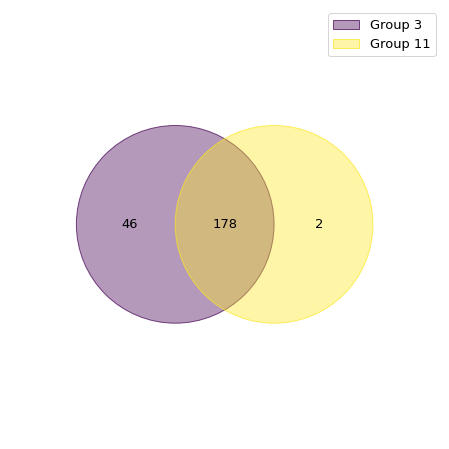

------------------ 2022-08-09 20:55:37 ------------------
DEBUG: at <ipython-input-19-c330b94a1460>:71 predict_groups_preferences
Figure saved in output/figures/preferred_subs/2_groups.png
------------------ 2022-08-09 20:55:37 ------------------
------------------ 2022-08-09 20:55:37 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Predicting group 2 with users {2104, 15217, 7691, 21675}
------------------ 2022-08-09 20:55:37 ------------------


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


  0%|          | 0/1636 [00:00<?, ?it/s]

------------------ 2022-08-09 20:55:45 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 2 prefers 197/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_rs68z', 't3_evitta', 't3_fth71r', 't3_da7nnx', 't3_chaprv', 't3_5u6x9a', 't3_fph14e', 't3_ajor0x', 't3_ezu180', 't3_dj98gs', 't3_ezpa6g', 't3_277gmt', 't3_ff6mlx', 't3_f4hj5z', 't3_e83tkz', 't3_afw9op', 't3_fnhtmi', 't3_8bi46v', 't3_drftex', 't3_f0jys1', 't3_ga6wq3', 't3_f3bdh1', 't3_ff44x8', 't3_x72pa', 't3_fo9wry', 't3_g4csti', 't3_fwhy48', 't3_g7irww', 't3_5do4uv', 't3_ev9tw3', 't3_eu63by', 't3_dvyohj', 't3_g64hnw', 't3_2ewnut', 't3_bxjn21', 't3_e0znx3', 't3_ds9jwb', 't3_dy7bkz', 't3_gurail', 't3_dsp5vf', 't3_db4wdp', 't3_ew7z9g', 't3_e6fscx', 't3_6d4u8a', 't3_eubyn4', 't3_cwnqmu', 't3_dr7a52', 't3_elw5qc', 't3_fwic8e', 't3_8fdk08', 't3_8vsfzz', 't3_gej3g5', 't3_fwo13s', 't3_ei2fjh', 't3_gsotvv', 't3_2baxqm', 't3_f5we4p', 't3_czpzcc', 't3_da1p43', 't3

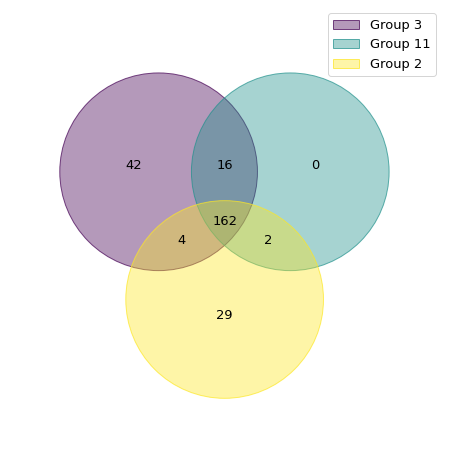

------------------ 2022-08-09 20:55:45 ------------------
DEBUG: at <ipython-input-19-c330b94a1460>:71 predict_groups_preferences
Figure saved in output/figures/preferred_subs/3_groups.png
------------------ 2022-08-09 20:55:45 ------------------
------------------ 2022-08-09 20:55:45 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Have similar center with existing group
------------------ 2022-08-09 20:55:45 ------------------
------------------ 2022-08-09 20:55:45 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Predicting group 9 with users {22403, 21188, 10598, 12840, 3497, 30923, 11628, 7411, 22132, 8283, 9883, 2270, 7327}
------------------ 2022-08-09 20:55:45 ------------------


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


  0%|          | 0/5317 [00:00<?, ?it/s]

------------------ 2022-08-09 20:56:32 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 9 prefers 229/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_evitta', 't3_fth71r', 't3_gurail', 't3_da7nnx', 't3_g4knxi', 't3_ew7z9g', 't3_chaprv', 't3_f9cz7a', 't3_fph14e', 't3_ezu180', 't3_dj98gs', 't3_ezpa6g', 't3_ep58m9', 't3_ff6mlx', 't3_cwnqmu', 't3_e83tkz', 't3_go2u76', 't3_elw5qc', 't3_fh0pjm', 't3_fnhtmi', 't3_cpxka8', 't3_drftex', 't3_f0jys1', 't3_ga6wq3', 't3_f3bdh1', 't3_ff44x8', 't3_fo9wry', 't3_g4csti', 't3_fwhy48', 't3_5do4uv', 't3_gej3g5', 't3_ev9tw3', 't3_eu63by', 't3_dvyohj', 't3_gsotvv', 't3_g64hnw', 't3_2ewnut', 't3_bxjn21', 't3_f5we4p', 't3_e0znx3', 't3_ds9jwb', 't3_da1p43', 't3_esdny3', 't3_gri84y', 't3_g0mr0i', 't3_gawci2', 't3_du38sm', 't3_gb1hzc', 't3_d84b83', 't3_gkhm0w', 't3_cbomq4', 't3_c1sovv', 't3_dsp5vf', 't3_db4wdp', 't3_evlj22', 't3_gjl0am', 't3_e6fscx', 't3_ebw6qd', 't3_ajqahj', '

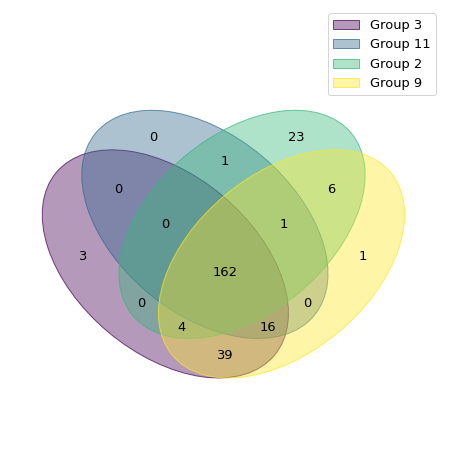

------------------ 2022-08-09 20:56:32 ------------------
DEBUG: at <ipython-input-19-c330b94a1460>:71 predict_groups_preferences
Figure saved in output/figures/preferred_subs/4_groups.png
------------------ 2022-08-09 20:56:32 ------------------
------------------ 2022-08-09 20:56:32 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Have similar center with existing group
------------------ 2022-08-09 20:56:32 ------------------
------------------ 2022-08-09 20:56:32 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Predicting group 4 with users {9315, 29187, 12966, 22473, 4618, 29131, 12044, 20749, 26925, 27309, 28972, 5754, 2905, 4698, 20891, 22877, 30846, 4223}
------------------ 2022-08-09 20:56:32 ------------------


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:05<00:00,  5.30it/s]


  0%|          | 0/7362 [00:00<?, ?it/s]

------------------ 2022-08-09 20:57:51 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 4 prefers 210/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_evitta', 't3_fth71r', 't3_5u6x9a', 't3_dj98gs', 't3_e83tkz', 't3_f0jys1', 't3_ga6wq3', 't3_f3bdh1', 't3_ff44x8', 't3_g4csti', 't3_fwhy48', 't3_g7irww', 't3_5do4uv', 't3_eu63by', 't3_dvyohj', 't3_g64hnw', 't3_2ewnut', 't3_bxjn21', 't3_ds9jwb', 't3_chaprv', 't3_fph14e', 't3_elw5qc', 't3_fnhtmi', 't3_8bi46v', 't3_drftex', 't3_fo9wry', 't3_f5we4p', 't3_dy7bkz', 't3_gurail', 't3_da7nnx', 't3_g4knxi', 't3_ew7z9g', 't3_6d4u8a', 't3_ajor0x', 't3_fgam46', 't3_277gmt', 't3_ff6mlx', 't3_cwnqmu', 't3_8fdk08', 't3_ev9tw3', 't3_rs68z', 't3_esdny3', 't3_gri84y', 't3_gkhm0w', 't3_cbomq4', 't3_dsp5vf', 't3_d4yes4', 't3_db4wdp', 't3_evlj22', 't3_gjl0am', 't3_e6fscx', 't3_ajqahj', 't3_f9cz7a', 't3_ezu180', 't3_g1sexx', 't3_ezpa6g', 't3_ep58m9', 't3_f4hj5z', 't3_go2u76', 't

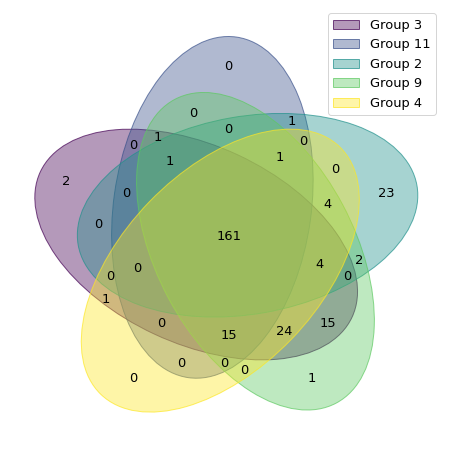

------------------ 2022-08-09 20:57:51 ------------------
DEBUG: at <ipython-input-19-c330b94a1460>:71 predict_groups_preferences
Figure saved in output/figures/preferred_subs/5_groups.png
------------------ 2022-08-09 20:57:51 ------------------
------------------ 2022-08-09 20:57:51 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Predicting group 6 with users {26432, 6849, 31104, 4807, 3433, 28428, 26669, 12558, 12911, 12177, 11698, 17266, 23603, 28437, 31258, 28475, 28732}
------------------ 2022-08-09 20:57:51 ------------------


  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:05<00:00,  5.36it/s]


  0%|          | 0/6953 [00:00<?, ?it/s]

------------------ 2022-08-09 20:59:05 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 6 prefers 254/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_rs68z', 't3_evitta', 't3_esdny3', 't3_fth71r', 't3_gb1hzc', 't3_gkhm0w', 't3_gurail', 't3_da7nnx', 't3_g4knxi', 't3_evlj22', 't3_ew7z9g', 't3_gjl0am', 't3_cvpwu3', 't3_f2kle8', 't3_f9cz7a', 't3_5u6x9a', 't3_fph14e', 't3_ezu180', 't3_dj98gs', 't3_fgam46', 't3_g66qb8', 't3_ezpa6g', 't3_ep58m9', 't3_ew6r3x', 't3_ff6mlx', 't3_f34dk6', 't3_cwnqmu', 't3_e83tkz', 't3_go2u76', 't3_elw5qc', 't3_gtgzc3', 't3_fnhtmi', 't3_fwic8e', 't3_f0jys1', 't3_ga6wq3', 't3_f3bdh1', 't3_ff44x8', 't3_fo9wry', 't3_g4csti', 't3_elfuix', 't3_fwhy48', 't3_g7irww', 't3_gbabln', 't3_gej3g5', 't3_ev9tw3', 't3_fwo13s', 't3_eu63by', 't3_g85fxp', 't3_dvyohj', 't3_gsotvv', 't3_g64hnw', 't3_2ewnut', 't3_bxjn21', 't3_f9hr5p', 't3_gnnq8y', 't3_f5we4p', 't3_ds9jwb', 't3_dy7bkz', 't3_gri84y', 't

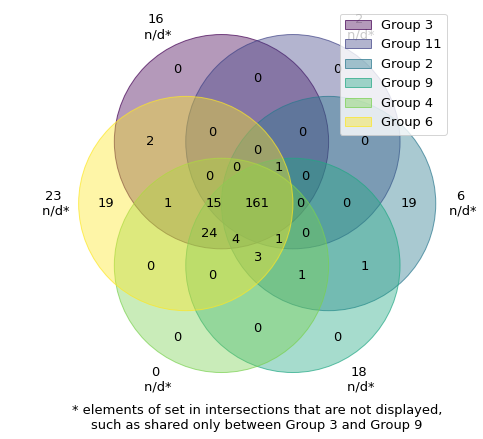

------------------ 2022-08-09 20:59:05 ------------------
DEBUG: at <ipython-input-19-c330b94a1460>:71 predict_groups_preferences
Figure saved in output/figures/preferred_subs/6_groups.png
------------------ 2022-08-09 20:59:05 ------------------
------------------ 2022-08-09 20:59:05 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Have similar center with existing group
------------------ 2022-08-09 20:59:05 ------------------
------------------ 2022-08-09 20:59:05 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Predicting group 15 with users {9888, 4033, 6791, 4686, 19534, 11314, 5939, 22194}
------------------ 2022-08-09 20:59:05 ------------------


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:02<00:00,  5.38it/s]


  0%|          | 0/3272 [00:00<?, ?it/s]

------------------ 2022-08-09 20:59:24 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 15 prefers 179/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_rs68z', 't3_evitta', 't3_fth71r', 't3_da7nnx', 't3_fph14e', 't3_dj98gs', 't3_277gmt', 't3_ff6mlx', 't3_cwnqmu', 't3_e83tkz', 't3_elw5qc', 't3_fnhtmi', 't3_drftex', 't3_f0jys1', 't3_ga6wq3', 't3_f3bdh1', 't3_ff44x8', 't3_x72pa', 't3_fo9wry', 't3_g4csti', 't3_fwhy48', 't3_9gynhb', 't3_g7irww', 't3_5do4uv', 't3_eu63by', 't3_dvyohj', 't3_g64hnw', 't3_2ewnut', 't3_bxjn21', 't3_f5we4p', 't3_e0znx3', 't3_dy7bkz', 't3_6axjuw', 't3_gurail', 't3_dsp5vf', 't3_g4knxi', 't3_db4wdp', 't3_ew7z9g', 't3_e6fscx', 't3_6d4u8a', 't3_chaprv', 't3_f9cz7a', 't3_ajor0x', 't3_ezu180', 't3_fgam46', 't3_ezpa6g', 't3_go2u76', 't3_fh0pjm', 't3_afw9op', 't3_8bi46v', 't3_fwic8e', 't3_elfuix', 't3_8vsfzz', 't3_gbabln', 't3_gej3g5', 't3_ev9tw3', 't3_fwo13s', 't3_gsotvv', 't3_2baxqm', 't

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:02<00:00,  5.55it/s]


  0%|          | 0/2863 [00:00<?, ?it/s]

------------------ 2022-08-09 20:59:41 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 5 prefers 95/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_rs68z', 't3_evitta', 't3_fth71r', 't3_6d4u8a', 't3_f9cz7a', 't3_fph14e', 't3_dj98gs', 't3_277gmt', 't3_e83tkz', 't3_elw5qc', 't3_afw9op', 't3_fnhtmi', 't3_f0jys1', 't3_ga6wq3', 't3_f3bdh1', 't3_ff44x8', 't3_x72pa', 't3_fo9wry', 't3_g4csti', 't3_fwhy48', 't3_g7irww', 't3_5do4uv', 't3_eu63by', 't3_dvyohj', 't3_2ewnut', 't3_bxjn21', 't3_f5we4p', 't3_dy7bkz', 't3_da7nnx', 't3_db4wdp', 't3_ew7z9g', 't3_e6fscx', 't3_chaprv', 't3_ff6mlx', 't3_cwnqmu', 't3_945bik', 't3_8bi46v', 't3_fwic8e', 't3_drftex', 't3_9gynhb', 't3_ev9tw3', 't3_g64hnw', 't3_ds9jwb', 't3_6axjuw', 't3_gkhm0w', 't3_gurail', 't3_g4knxi', 't3_e4yvlb', 't3_5u6x9a', 't3_ajor0x', 't3_ezu180', 't3_ezpa6g', 't3_ep58m9', 't3_7unohu', 't3_28h4n8', 't3_8fdk08', 't3_92lfgs', 't3_dybsmt', 't3_8vsfzz', 't3_

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


  0%|          | 0/1636 [00:00<?, ?it/s]

------------------ 2022-08-09 20:59:49 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 20 prefers 75/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_dy7bkz', 't3_rs68z', 't3_fth71r', 't3_6axjuw', 't3_da7nnx', 't3_g4knxi', 't3_db4wdp', 't3_ew7z9g', 't3_6d4u8a', 't3_f9cz7a', 't3_fph14e', 't3_dj98gs', 't3_ezpa6g', 't3_277gmt', 't3_ff6mlx', 't3_cwnqmu', 't3_e83tkz', 't3_elw5qc', 't3_fnhtmi', 't3_f0jys1', 't3_ga6wq3', 't3_f3bdh1', 't3_ff44x8', 't3_x72pa', 't3_fo9wry', 't3_g4csti', 't3_fwhy48', 't3_9gynhb', 't3_g7irww', 't3_5do4uv', 't3_eu63by', 't3_dvyohj', 't3_2ewnut', 't3_bxjn21', 't3_f5we4p', 't3_evitta', 't3_gurail', 't3_dsp5vf', 't3_e4yvlb', 't3_e6fscx', 't3_5u6x9a', 't3_ezu180', 't3_g66qb8', 't3_ep58m9', 't3_8fdk08', 't3_d2qz77', 't3_drftex', 't3_fwo13s', 't3_g85fxp', 't3_gsotvv', 't3_2baxqm', 't3_g64hnw', 't3_ds9jwb', 't3_da1p43', 't3_gri84y', 't3_gb1hzc', 't3_gkhm0w', 't3_ajqahj', 't3_chaprv', 't3

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:02<00:00,  5.56it/s]


  0%|          | 0/2863 [00:00<?, ?it/s]

------------------ 2022-08-09 21:00:06 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 1 prefers 213/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_e0znx3', 't3_ds9jwb', 't3_dy7bkz', 't3_rs68z', 't3_evitta', 't3_c6go07', 't3_esdny3', 't3_fth71r', 't3_gri84y', 't3_g0mr0i', 't3_du38sm', 't3_gb1hzc', 't3_e8t82f', 't3_d84b83', 't3_6axjuw', 't3_fn8x9t', 't3_gkhm0w', 't3_gurail', 't3_f8aj4i', 't3_da7nnx', 't3_cbomq4', 't3_c1sovv', 't3_dsp5vf', 't3_g4knxi', 't3_d4yes4', 't3_db4wdp', 't3_evlj22', 't3_ew7z9g', 't3_f7berp', 't3_fdv46r', 't3_gjl0am', 't3_e4yvlb', 't3_cvpwu3', 't3_f2kle8', 't3_e6fscx', 't3_6d4u8a', 't3_evsv0h', 't3_ebw6qd', 't3_ajqahj', 't3_chaprv', 't3_f9cz7a', 't3_eb3ckl', 't3_evo35n', 't3_deqctv', 't3_dhh5y9', 't3_fph14e', 't3_ezobx8', 't3_ajor0x', 't3_ezu180', 't3_dj98gs', 't3_fgam46', 't3_f828xm', 't3_eubyn4', 't3_g66qb8', 't3_8yla41', 't3_g1sexx', 't3_g4mmmb', 't3_ezpa6g', 't3_ejwcw0', 't

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


  0%|          | 0/818 [00:00<?, ?it/s]

------------------ 2022-08-09 21:00:10 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 23 prefers 197/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_dy7bkz', 't3_rs68z', 't3_evitta', 't3_fth71r', 't3_du38sm', 't3_gb1hzc', 't3_6axjuw', 't3_gurail', 't3_da7nnx', 't3_c1sovv', 't3_dsp5vf', 't3_g4knxi', 't3_d4yes4', 't3_db4wdp', 't3_ew7z9g', 't3_e6fscx', 't3_6d4u8a', 't3_ebw6qd', 't3_ajqahj', 't3_chaprv', 't3_f9cz7a', 't3_5u6x9a', 't3_dhh5y9', 't3_fph14e', 't3_ajor0x', 't3_ezu180', 't3_dj98gs', 't3_ezpa6g', 't3_277gmt', 't3_95q298', 't3_ff6mlx', 't3_f4hj5z', 't3_7unohu', 't3_cwnqmu', 't3_e75hrh', 't3_e83tkz', 't3_dxtl9w', 't3_6stdi4', 't3_go2u76', 't3_f7f7wg', 't3_945bik', 't3_elw5qc', 't3_a1avqd', 't3_afw9op', 't3_gtgzc3', 't3_fnhtmi', 't3_8bi46v', 't3_8fdk08', 't3_d2qz77', 't3_drftex', 't3_f0jys1', 't3_ga6wq3', 't3_7koj6o', 't3_f3bdh1', 't3_bv96ya', 't3_ff44x8', 't3_x72pa', 't3_fo9wry', 't3_g4csti', 't

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


  0%|          | 0/818 [00:00<?, ?it/s]

------------------ 2022-08-09 21:00:13 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 24 prefers 89/409 submissions (%upvotes ≥ 0.5) (sorted using %upvotes): ['t3_dy7bkz', 't3_rs68z', 't3_evitta', 't3_fth71r', 't3_6axjuw', 't3_gkhm0w', 't3_gurail', 't3_da7nnx', 't3_c1sovv', 't3_g4knxi', 't3_db4wdp', 't3_ew7z9g', 't3_fdv46r', 't3_e4yvlb', 't3_e6fscx', 't3_6d4u8a', 't3_ajqahj', 't3_f9cz7a', 't3_eb3ckl', 't3_5u6x9a', 't3_fph14e', 't3_ajor0x', 't3_ezu180', 't3_dj98gs', 't3_ezpa6g', 't3_277gmt', 't3_ep58m9', 't3_ff6mlx', 't3_cwnqmu', 't3_e75hrh', 't3_e83tkz', 't3_945bik', 't3_elw5qc', 't3_afw9op', 't3_fnhtmi', 't3_8bi46v', 't3_fwic8e', 't3_8fdk08', 't3_drftex', 't3_f0jys1', 't3_ga6wq3', 't3_f3bdh1', 't3_ff44x8', 't3_x72pa', 't3_fo9wry', 't3_g4csti', 't3_elfuix', 't3_dybsmt', 't3_fwhy48', 't3_9gynhb', 't3_g7irww', 't3_5do4uv', 't3_gej3g5', 't3_fwo13s', 't3_eu63by', 't3_dvyohj', 't3_gsotvv', 't3_2baxqm', 't3_g64hnw', 't3

In [19]:

def predict_groups_preferences(users_in_groups, unique_submissions:dict, upvote_ratio_thres = 0.5, group_centers=None, user_grouping_method = "rep", existing_votes = None, existing_user_updown_votes = None, pred_group_votes_info = None):
    # users_in_groups = existing_user_votes.most_common(3)
    groups_preferred_submissions = {}
    groups_preferred_submissions_text = {}
    groups_submission_upvote_count_matrix = np.zeros([len(users_in_groups), len(unique_submissions)])
    unique_submissions_ids = list(unique_submissions.keys())
    used_group_centers = []
    if os.path.exists(config["preferred_submissions_venn_figure_dir"]):
        shutil.rmtree(config["preferred_submissions_venn_figure_dir"])
    os.makedirs(config["preferred_submissions_venn_figure_dir"], exist_ok=True)
    for group_x in users_in_groups:
        if ((not ("single_user_as_group" in user_grouping_method and len(users_in_groups[group_x]) == 1)) and (not ("none" in user_grouping_method and len(users_in_groups[group_x]) == 0)) and len(users_in_groups[group_x]) <= config["group_user_num_lower_thres"]) or ("all_user_as_group" not in user_grouping_method and len(users_in_groups[group_x]) > config["group_user_num_upper_thres"]): # keep middle sized centers
            continue
        if group_centers is not None: # only keep not similar centers
            group_x_center = group_centers[group_x]
            similar_center = False
            for center in used_group_centers:
                if np.dot(group_x_center, center) > 0:
                    similar_center = True
                    break
            if similar_center:
                # continue
                print_log(config["log_path"], "Have similar center with existing group")
            used_group_centers.append(group_x_center)

        ################ predicting votes of some users and some submissions ##################
        print_log(config["log_path"], f"Predicting group {group_x} with users {users_in_groups[group_x]}")
        
        if len(users_in_groups[group_x]) > 0:
            group_x_subreddit_submissions_data = convert_group_users_subreddit_submissions_data(users_in_groups[group_x], unique_submissions)
            if group_x not in pred_group_votes_info:
                predicted_group_x_submissions_votes = predict_group_users_submissions_votes(model, group_x_subreddit_submissions_data, batch_size)
                group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_user_submission_vote_score_matrix(predicted_group_x_submissions_votes, users_in_groups[group_x], group_x_subreddit_submissions_data, existing_votes, upvote_confidence_thres=upvote_confidence_thres)
                
                pred_group_votes_info[group_x] = pred_group_x_subreddit_submission_vote_score_matrix
            else:
                debug("Using existing pred_group_votes_info")
                pred_group_x_subreddit_submission_vote_score_matrix = pred_group_votes_info[group_x]
                group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_user_submission_vote_score_matrix(None, users_in_groups[group_x], group_x_subreddit_submissions_data, existing_votes, existing_pred_user_submission_vote_score_matrix=pred_group_x_subreddit_submission_vote_score_matrix, upvote_confidence_thres=upvote_confidence_thres)
                # group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = pred_group_votes_info[group_x]
        elif len(users_in_groups[group_x]) == 0: # no user in this group, i.e., without curation, just count real votes
            group_x_submission_votes, group_x_confidence, pred_group_x_subreddit_submission_vote_score_matrix, pred_group_x_subreddit_submission_vote_matrix = get_group_users_real_vote(list(a_subreddit_active_user_i_user_map.values()), unique_submissions, existing_votes, metric = "upvote_rate")
        
        group_x_preferred_submissions, group_x_preferred_submissions_ranking = get_group_users_preferred_submissions(group_x_submission_votes, upvote_ratio_thres = upvote_ratio_thres)
    
        pred_group_x_subreddit_submission_vote_matrix_np = pred_group_x_subreddit_submission_vote_matrix[unique_submissions_ids].to_numpy()
        pred_group_x_subreddit_submission_vote_matrix_np = pred_group_x_subreddit_submission_vote_matrix_np[pred_group_x_subreddit_submission_vote_matrix_np.sum(axis=1) >= 0]
        groups_submission_upvote_count_matrix[group_x] = pred_group_x_subreddit_submission_vote_matrix_np.sum(axis=0).astype(float)/len(pred_group_x_subreddit_submission_vote_matrix_np)
        

        ################# Display submissions preferred by each group of users ######################

        if "single_user_as_group" in user_grouping_method:
            user_train_vote_prompt = f"voted {existing_user_updown_votes[list(users_in_groups[group_x])[0]]} in training data, prediction confidence {list(group_x_confidence.values())[0]}, "
        else:
            user_train_vote_prompt = ""
            
        group_x_preferred_ranked_submissions = group_x_preferred_submissions_ranking[:len(group_x_preferred_submissions)]
        groups_preferred_submissions[f"Group {group_x}"] = group_x_preferred_submissions
        
        # convert submission text content
        group_x_preferred_ranked_submissions_text = get_submissions_text(group_x_preferred_ranked_submissions)
        groups_preferred_submissions_text[f"Group {group_x}"] = group_x_preferred_ranked_submissions_text
            
        print_log(config["log_path"], f"Users in group {group_x} {user_train_vote_prompt}prefers {len(group_x_preferred_submissions)}/{len(unique_submissions)} submissions (%upvotes ≥ {upvote_ratio_thres}) (sorted using %upvotes): {group_x_preferred_ranked_submissions}") # , with text {group_x_preferred_ranked_submissions_text}

        # draw venn diagram            
        if len(groups_preferred_submissions) > 1 and len(groups_preferred_submissions) <=6 and sum([len(_) for _ in groups_preferred_submissions.values()]) > 0:
            ax = venn(groups_preferred_submissions) if len(groups_preferred_submissions) <=5 else pseudovenn(groups_preferred_submissions)
            plt.show()
            figure_path = f"{config['preferred_submissions_venn_figure_dir']}/{len(groups_preferred_submissions)}_groups.png"
            ax.figure.savefig(figure_path)
            debug(f"Figure saved in {figure_path}")
    return groups_preferred_submissions, groups_preferred_submissions_text, groups_submission_upvote_count_matrix

model = model.to(model.device); model.eval()
groups_preferred_submissions, groups_preferred_submissions_text, groups_submission_upvote_count_matrix = predict_groups_preferences(users_in_groups, submissions_before_curation, group_centers=group_centers, user_grouping_method=user_grouping_method, existing_votes=existing_votes, existing_user_updown_votes=existing_user_updown_votes, pred_group_votes_info = pred_group_votes_info, upvote_ratio_thres = upvote_ratio_thres)
if config["submission_source"] == "custom":
    debug(groups_submission_upvote_count_matrix)
    print(f"You can post immediately in {[group_x for group_x in groups_preferred_submissions if len(groups_preferred_submissions[group_x]) > 0]}. You will need to wait for more votes to post in {[group_x for group_x in groups_preferred_submissions if len(groups_preferred_submissions[group_x]) == 0]} -- your post will stay in the background first. Currently, ", end = "")
    for group_x in groups_preferred_submissions:
        group_x_int = int(group_x.split(" ")[-1])
        print(f"{100 * groups_submission_upvote_count_matrix[group_x_int, 0]}% of the curators in {group_x} are predicted to upvote on your post; ", end = "")
        


##### Calculate Pearson correlation of different groups

In [22]:
# print(groups_submission_upvote_count_matrix)
groups_submission_upvote_count_matrix_nonzero = groups_submission_upvote_count_matrix[groups_submission_upvote_count_matrix.sum(axis = 1) != 0]
group_preference_pearson_corr = np.corrcoef(groups_submission_upvote_count_matrix_nonzero) # (697, 697)
debug(group_preference_pearson_corr)

------------------ 2022-08-09 21:24:24 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-22-378e9067c5e8>:4 <module>
0 / 11.  ? ndarray size: (12, 12) val: [[1.         0.71963643 0.97521787 0.95907753 0.77714388 0.9548819
  0.94358708 0.95166712 0.88659926 0.62596531 0.78814198 0.56115842]
 [0.71963643 1.         0.73429423 0.81581821 0.89233961 0.75652527
  0.76988254 0.82608398 0.87520832 0.77171375 0.82340047 0.71769068]
 [0.97521787 0.73429423 1.         0.96676303 0.78377286 0.97207368
  0.96655344 0.95057356 0.89143536 0.62093172 0.76927329 0.55736555]
 [0.95907753 0.81581821 0.96676303 1.         0.86455928 0.96507146
  0.96342657 0.97922469 0.93700923 0.69731823 0.84036425 0.63625662]
 [0.77714388 0.89233961 0.78377286 0.86455928 1.         0.79550381
  0.79253081 0.87293938 0.91288401 0.86360244 0.8487122  0.81892231]
 [0.9548819  0.75652527 0.97207368 0.96507146 0.79550381 1.
  0.96986837 0.94570818 0.88287012 0.60244616 0.76755357 0.54188087]
 [0.94358708 0.7698825

Group 3: average sentiment -0.3727, all classes {'/News': 0.022321428571428572, '/Online Communities/Social Networks': 0.004464285714285714, '/Online Communities/Blogging Resources & Services': 0.004464285714285714, '/News/Politics': 0.11607142857142858, '/Law & Government/Public Safety/Law Enforcement': 0.004464285714285714, '/Law & Government/Legal/Legal Services': 0.004464285714285714, '/Law & Government/Legal/Legal Education': 0.004464285714285714, '/Jobs & Education/Education/Colleges & Universities': 0.004464285714285714, '/Arts & Entertainment': 0.013392857142857142, '/Law & Government/Legal': 0.004464285714285714, '/Autos & Vehicles/Vehicle Codes & Driving Laws': 0.004464285714285714, '/Law & Government/Public Safety': 0.004464285714285714, '/Law & Government/Government': 0.008928571428571428, '/Autos & Vehicles/Motor Vehicles (By Type)/Hybrid & Alternative Vehicles': 0.004464285714285714, '/Sensitive Subjects': 0.008928571428571428, '/Law & Government': 0.017857142857142856, '

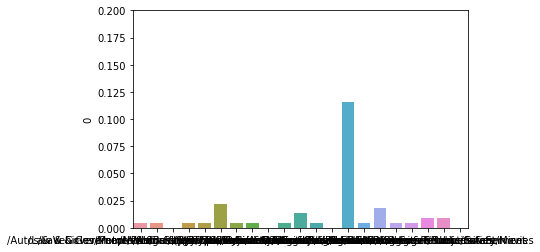

Group 11: average sentiment -0.3727, all classes {'/News': 0.022222222222222223, '/News/Politics': 0.1111111111111111, '/Law & Government/Public Safety/Law Enforcement': 0.005555555555555556, '/Law & Government/Legal/Legal Services': 0.005555555555555556, '/Law & Government/Legal/Legal Education': 0.005555555555555556, '/Jobs & Education/Education/Colleges & Universities': 0.005555555555555556, '/Arts & Entertainment': 0.016666666666666666, '/Law & Government/Legal': 0.005555555555555556, '/Autos & Vehicles/Vehicle Codes & Driving Laws': 0.005555555555555556, '/Law & Government/Public Safety': 0.005555555555555556, '/Law & Government/Government': 0.005555555555555556, '/Autos & Vehicles/Motor Vehicles (By Type)/Hybrid & Alternative Vehicles': 0.005555555555555556, '/Sensitive Subjects': 0.011111111111111112, '/Law & Government': 0.016666666666666666, '/People & Society/Social Issues & Advocacy': 0.005555555555555556}


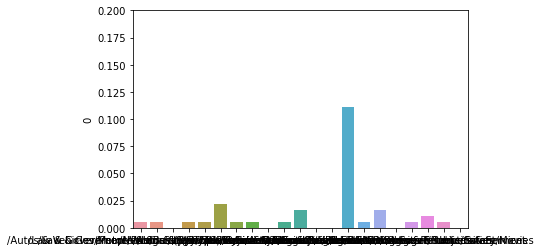

Group 2: average sentiment -0.3727, all classes {'/News': 0.02030456852791878, '/News/Politics': 0.10152284263959391, '/Law & Government/Public Safety/Law Enforcement': 0.005076142131979695, '/Law & Government/Legal/Legal Services': 0.005076142131979695, '/Law & Government/Legal/Legal Education': 0.005076142131979695, '/Jobs & Education/Education/Colleges & Universities': 0.005076142131979695, '/Arts & Entertainment': 0.02030456852791878, '/Law & Government/Legal': 0.01015228426395939, '/Business & Industrial': 0.01015228426395939, '/News/Business News': 0.01015228426395939, '/Autos & Vehicles/Vehicle Codes & Driving Laws': 0.005076142131979695, '/Law & Government/Public Safety': 0.005076142131979695, '/Law & Government/Government': 0.005076142131979695, '/People & Society/Social Sciences': 0.005076142131979695, '/Sensitive Subjects': 0.01015228426395939, '/Law & Government': 0.015228426395939087, '/People & Society/Social Issues & Advocacy': 0.005076142131979695}


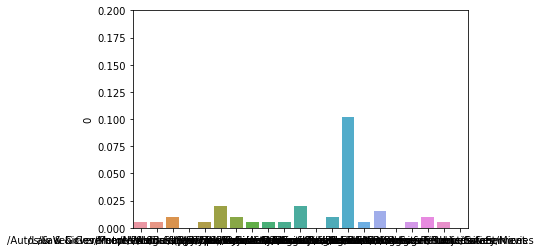

Group 9: average sentiment -0.3727, all classes {'/News': 0.021834061135371178, '/Online Communities/Social Networks': 0.004366812227074236, '/Online Communities/Blogging Resources & Services': 0.004366812227074236, '/News/Politics': 0.11790393013100436, '/Law & Government/Public Safety/Law Enforcement': 0.004366812227074236, '/Law & Government/Legal/Legal Services': 0.004366812227074236, '/Law & Government/Legal/Legal Education': 0.004366812227074236, '/Jobs & Education/Education/Colleges & Universities': 0.004366812227074236, '/Arts & Entertainment': 0.013100436681222707, '/Business & Industrial': 0.004366812227074236, '/News/Business News': 0.004366812227074236, '/Law & Government/Legal': 0.004366812227074236, '/Autos & Vehicles/Vehicle Codes & Driving Laws': 0.004366812227074236, '/Law & Government/Public Safety': 0.004366812227074236, '/Law & Government/Government': 0.008733624454148471, '/Autos & Vehicles/Motor Vehicles (By Type)/Hybrid & Alternative Vehicles': 0.0043668122270742

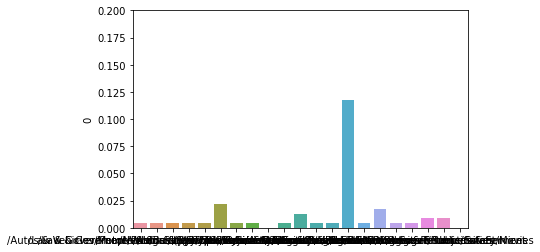

Group 4: average sentiment -0.3727, all classes {'/News': 0.01904761904761905, '/News/Politics': 0.11904761904761904, '/Law & Government/Public Safety/Law Enforcement': 0.004761904761904762, '/Law & Government/Legal/Legal Services': 0.004761904761904762, '/Law & Government/Legal/Legal Education': 0.004761904761904762, '/Jobs & Education/Education/Colleges & Universities': 0.004761904761904762, '/Arts & Entertainment': 0.014285714285714285, '/Law & Government/Legal': 0.004761904761904762, '/Autos & Vehicles/Vehicle Codes & Driving Laws': 0.004761904761904762, '/Law & Government/Public Safety': 0.004761904761904762, '/Law & Government/Government': 0.009523809523809525, '/Autos & Vehicles/Motor Vehicles (By Type)/Hybrid & Alternative Vehicles': 0.004761904761904762, '/Sensitive Subjects': 0.009523809523809525, '/Law & Government': 0.01904761904761905, '/People & Society/Social Issues & Advocacy': 0.004761904761904762}


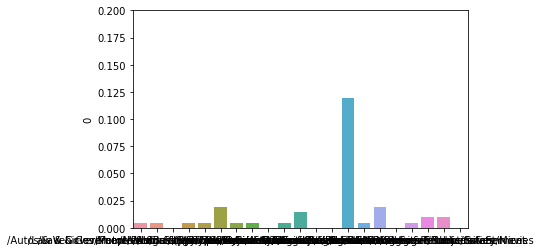

Group 6: average sentiment -0.3727, all classes {'/News': 0.023622047244094488, '/Online Communities/Social Networks': 0.003937007874015748, '/Online Communities/Blogging Resources & Services': 0.003937007874015748, '/Arts & Entertainment/Movies': 0.003937007874015748, '/News/Politics': 0.11023622047244094, '/Law & Government/Public Safety/Law Enforcement': 0.003937007874015748, '/Law & Government/Public Safety': 0.007874015748031496, '/Sensitive Subjects': 0.011811023622047244, '/Law & Government/Legal/Legal Services': 0.003937007874015748, '/Law & Government/Legal/Legal Education': 0.003937007874015748, '/Jobs & Education/Education/Colleges & Universities': 0.003937007874015748, '/Law & Government/Legal': 0.007874015748031496, '/Arts & Entertainment': 0.011811023622047244, '/Autos & Vehicles/Vehicle Codes & Driving Laws': 0.003937007874015748, '/Law & Government/Government': 0.007874015748031496, '/Autos & Vehicles/Motor Vehicles (By Type)/Hybrid & Alternative Vehicles': 0.0039370078

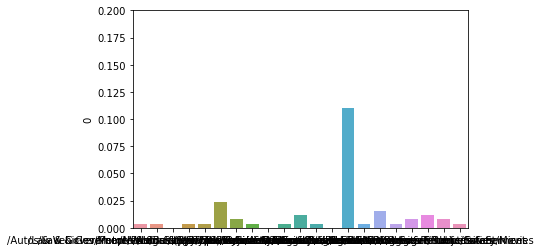

Group 15: average sentiment -0.3727, all classes {'/News/Politics': 0.10614525139664804, '/Law & Government/Public Safety/Law Enforcement': 0.00558659217877095, '/Law & Government/Legal/Legal Services': 0.00558659217877095, '/Law & Government/Legal/Legal Education': 0.00558659217877095, '/Jobs & Education/Education/Colleges & Universities': 0.00558659217877095, '/Law & Government/Legal': 0.00558659217877095, '/News': 0.01675977653631285, '/Arts & Entertainment': 0.01675977653631285, '/Business & Industrial': 0.00558659217877095, '/News/Business News': 0.00558659217877095, '/Law & Government/Public Safety': 0.00558659217877095, '/Law & Government/Government': 0.00558659217877095, '/Sensitive Subjects': 0.0111731843575419, '/Law & Government': 0.01675977653631285, '/People & Society/Social Issues & Advocacy': 0.00558659217877095}


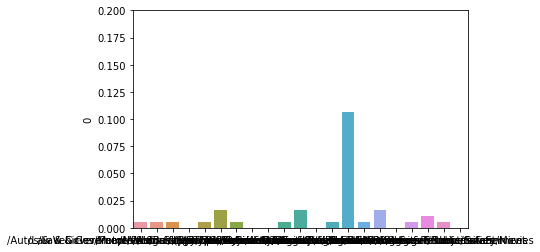

Group 5: average sentiment -0.3727, all classes {'/News/Politics': 0.10526315789473684, '/Law & Government/Public Safety/Law Enforcement': 0.010526315789473684, '/Law & Government/Legal/Legal Education': 0.010526315789473684, '/Jobs & Education/Education/Colleges & Universities': 0.010526315789473684, '/News': 0.031578947368421054, '/Arts & Entertainment': 0.010526315789473684, '/Law & Government/Public Safety': 0.010526315789473684, '/Law & Government/Government': 0.010526315789473684, '/Sensitive Subjects': 0.010526315789473684, '/Law & Government': 0.021052631578947368, '/People & Society/Social Issues & Advocacy': 0.010526315789473684}


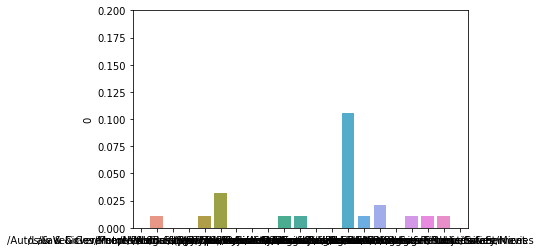

Group 20: average sentiment -0.3727, all classes {'/News/Politics': 0.09333333333333334, '/People & Society/Social Issues & Advocacy': 0.013333333333333334, '/News': 0.013333333333333334, '/Arts & Entertainment': 0.013333333333333334, '/Law & Government/Government': 0.013333333333333334, '/Law & Government': 0.02666666666666667, '/Law & Government/Legal/Legal Services': 0.013333333333333334, '/Sensitive Subjects': 0.013333333333333334, '/Law & Government/Legal/Legal Education': 0.013333333333333334, '/Jobs & Education/Education/Colleges & Universities': 0.013333333333333334}


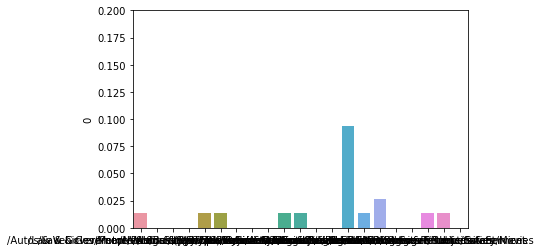

Group 1: average sentiment -0.3727, all classes {'/News': 0.023474178403755867, '/News/Politics': 0.11737089201877934, '/Law & Government/Public Safety/Law Enforcement': 0.004694835680751174, '/Law & Government/Legal/Legal Services': 0.004694835680751174, '/Law & Government/Legal/Legal Education': 0.004694835680751174, '/Jobs & Education/Education/Colleges & Universities': 0.004694835680751174, '/Arts & Entertainment': 0.014084507042253521, '/Law & Government/Legal': 0.004694835680751174, '/Autos & Vehicles/Vehicle Codes & Driving Laws': 0.004694835680751174, '/Law & Government/Public Safety': 0.004694835680751174, '/Law & Government/Government': 0.009389671361502348, '/Autos & Vehicles/Motor Vehicles (By Type)/Hybrid & Alternative Vehicles': 0.004694835680751174, '/Sensitive Subjects': 0.009389671361502348, '/Law & Government': 0.018779342723004695, '/People & Society/Social Issues & Advocacy': 0.004694835680751174}


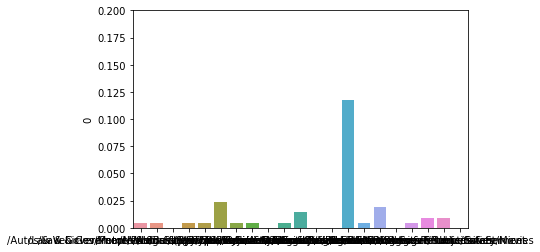

Group 23: average sentiment -0.3727, all classes {'/News': 0.02030456852791878, '/News/Politics': 0.09644670050761421, '/Law & Government/Public Safety/Law Enforcement': 0.005076142131979695, '/Law & Government/Legal/Legal Services': 0.005076142131979695, '/Law & Government/Legal/Legal Education': 0.005076142131979695, '/Jobs & Education/Education/Colleges & Universities': 0.005076142131979695, '/Law & Government/Legal': 0.01015228426395939, '/Arts & Entertainment': 0.015228426395939087, '/Autos & Vehicles/Vehicle Codes & Driving Laws': 0.005076142131979695, '/Law & Government/Public Safety': 0.005076142131979695, '/Law & Government/Government': 0.005076142131979695, '/Autos & Vehicles/Motor Vehicles (By Type)/Hybrid & Alternative Vehicles': 0.005076142131979695, '/Sensitive Subjects': 0.01015228426395939, '/Law & Government': 0.015228426395939087, '/People & Society/Social Issues & Advocacy': 0.005076142131979695}


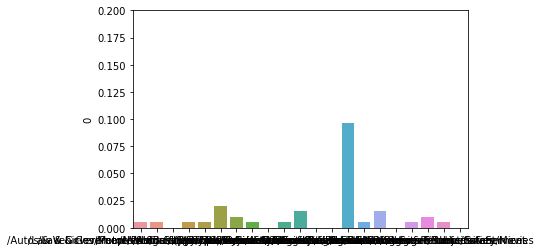

Group 24: average sentiment -0.3727, all classes {'/News/Politics': 0.12359550561797752, '/Law & Government/Public Safety/Law Enforcement': 0.011235955056179775, '/Law & Government/Legal/Legal Services': 0.011235955056179775, '/Law & Government/Legal/Legal Education': 0.011235955056179775, '/Jobs & Education/Education/Colleges & Universities': 0.011235955056179775, '/News': 0.02247191011235955, '/Arts & Entertainment': 0.02247191011235955, '/Law & Government/Government': 0.011235955056179775, '/Sensitive Subjects': 0.011235955056179775, '/Law & Government': 0.02247191011235955, '/People & Society/Social Issues & Advocacy': 0.011235955056179775}


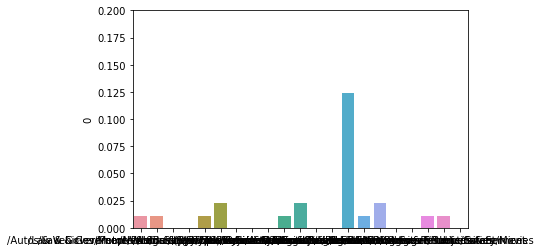

In [27]:
import seaborn as sns
all_classes = set()
groups_class_counter_rate = {}
for group_x in groups_preferred_submissions:
    submission_sentiments = []
    submission_classes = []
    group_preferred_submissions = groups_preferred_submissions[group_x]
    for submission_id in group_preferred_submissions:
        if submission_sentiment_map[submission_id]:
            submission_sentiments.append(submission_sentiment_map[submission_id])
        submission_classes.extend(submission_class_map[submission_id])
    avg_sentiment = np.mean(submission_sentiments) if len(submission_sentiments) > 0 else 0
    class_counter = Counter(submission_classes)
    all_classes.update(class_counter.keys())
    class_counter_rate = {k: v/len(group_preferred_submissions) for k, v in class_counter.items()}
    groups_class_counter_rate[group_x] = class_counter_rate
all_classes = list(all_classes)
for group_x in groups_class_counter_rate:
    class_counter_rate = groups_class_counter_rate[group_x]
    print(f"{group_x}: average sentiment {avg_sentiment:.4f}, all classes {class_counter_rate}")
    class_counter_rate = {cls: [class_counter_rate.get(cls, 0)] for cls in all_classes}
    class_counter_rate_df = pd.DataFrame.from_dict(class_counter_rate).transpose()
    ax = sns.barplot(x=class_counter_rate_df.index, y=class_counter_rate_df[0])
    ax.set(ylim=(0, 0.2))
    plt.show()
    plt.close()